# How dimensionality reduction affects cluster structure and visualisation, and how PCA, t-SNE, and UMAP differ mathematically and practically.

### 1. Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import umap

SEED = 42
np.random.seed(SEED)

### 2. Load & Inspect Data

In [8]:
data_path = "Mall_Customers.csv"  # adjust if needed
df = pd.read_csv(data_path)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
print(df.shape)
print(df.columns)
df.describe(include="all")

(200, 5)
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


### 3. Basic Preprocessing

We’ll:

Drop CustomerID

Encode Gender

Use all remaining numeric features

In [13]:
df = df.copy()

# Drop ID column if present
id_cols = [c for c in df.columns if "id" in c.lower()]
if id_cols:
    print("Dropping ID columns:", id_cols)
    df = df.drop(columns=id_cols)

# Encode Gender if present
if "Gender" in df.columns:
    le = LabelEncoder()
    df["Gender"] = le.fit_transform(df["Gender"])
    print("Encoded Gender:", dict(zip(le.classes_, le.transform(le.classes_))))

df.head()

Dropping ID columns: ['CustomerID']
Encoded Gender: {'Female': 0, 'Male': 1}


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


### Define feature matrix:

In [16]:
X = df.values
print("Feature shape:", X.shape)

Feature shape: (200, 4)


### Standardise features (very important for PCA/t-SNE/UMAP):

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(200, 4)

### 4. PCA (2D)

In [22]:
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance (2D):", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.33690046 0.26230645]
Total explained variance (2D): 0.5992069019819846


### 5. t-SNE (2D)

In [29]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="random",
    random_state=SEED
)

X_tsne = tsne.fit_transform(X_scaled)


### 6. UMAP (2D)

In [32]:
umap_reducer = umap.UMAP(
    n_components=2,
    random_state=SEED,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean"
)
X_umap = umap_reducer.fit_transform(X_scaled)
X_umap.shape

D:\Anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(200, 2)

### 7. K-Means on Each Embedding

We’ll pick k = 5 clusters (classic for this dataset, and works well visually).

In [35]:
K = 5

def kmeans_and_silhouette(X_emb, name):
    kmeans = KMeans(n_clusters=K, random_state=SEED)
    labels = kmeans.fit_predict(X_emb)
    sil = silhouette_score(X_emb, labels)
    print(f"{name}: Silhouette score = {sil:.4f}")
    return labels, sil

labels_pca, sil_pca = kmeans_and_silhouette(X_pca, "PCA")
labels_tsne, sil_tsne = kmeans_and_silhouette(X_tsne, "t-SNE")
labels_umap, sil_umap = kmeans_and_silhouette(X_umap, "UMAP")


PCA: Silhouette score = 0.4038
t-SNE: Silhouette score = 0.5279
UMAP: Silhouette score = 0.6441


D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### 8. 2D Scatter Plots (for the Report)

Helper function:

In [38]:
def plot_embedding(X_emb, labels, title, filename=None):
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=labels, cmap="tab10", s=30, alpha=0.8)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

### plots

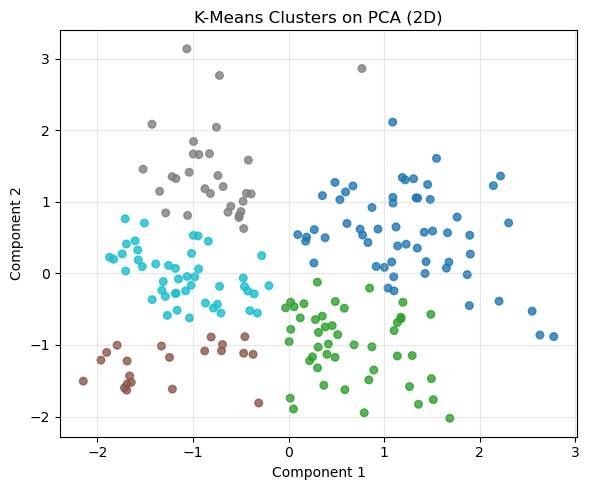

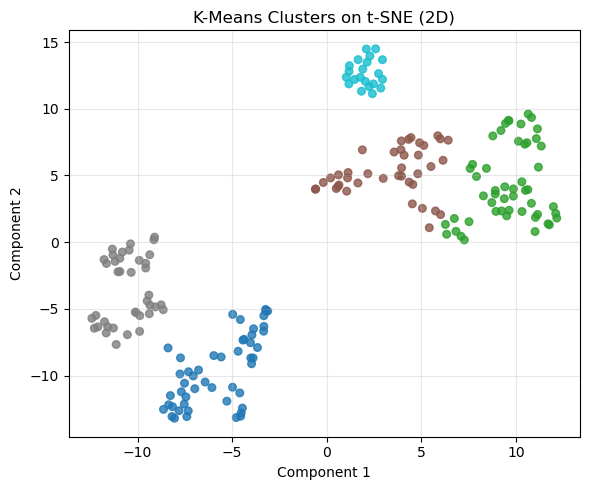

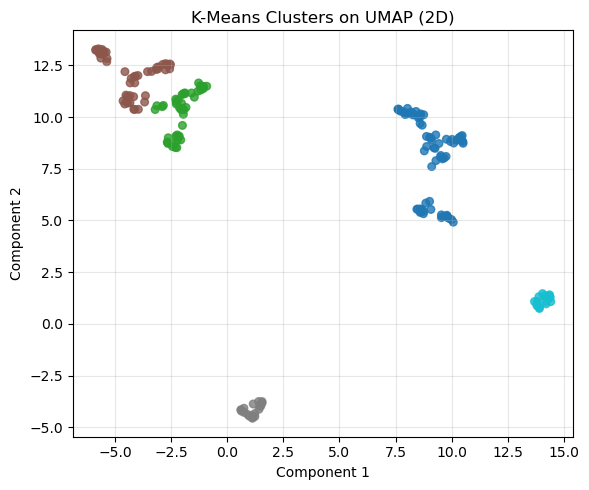

In [43]:
plot_embedding(X_pca, labels_pca,
               "K-Means Clusters on PCA (2D)",
               filename="pca_kmeans.png")

plot_embedding(X_tsne, labels_tsne,
               "K-Means Clusters on t-SNE (2D)",
               filename="tsne_kmeans.png")

plot_embedding(X_umap, labels_umap,
               "K-Means Clusters on UMAP (2D)",
               filename="umap_kmeans.png")


### 9. Compare Silhouette Scores (Bar Chart)

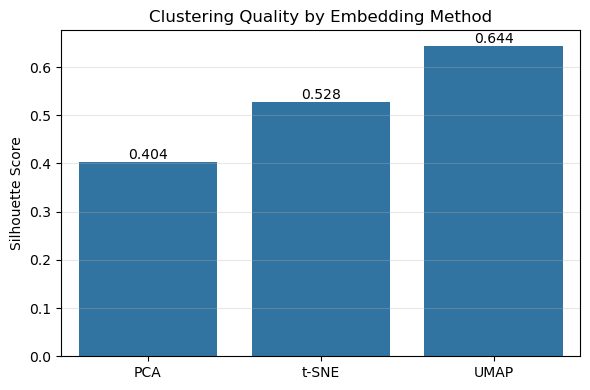

In [46]:
methods = ["PCA", "t-SNE", "UMAP"]
sil_scores = [sil_pca, sil_tsne, sil_umap]

plt.figure(figsize=(6, 4))
sns.barplot(x=methods, y=sil_scores)
plt.ylabel("Silhouette Score")
plt.title("Clustering Quality by Embedding Method")
for i, v in enumerate(sil_scores):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("silhouette_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

### 10. Optional: PCA Explained Variance Plot

For your report (to discuss PCA’s linear nature):

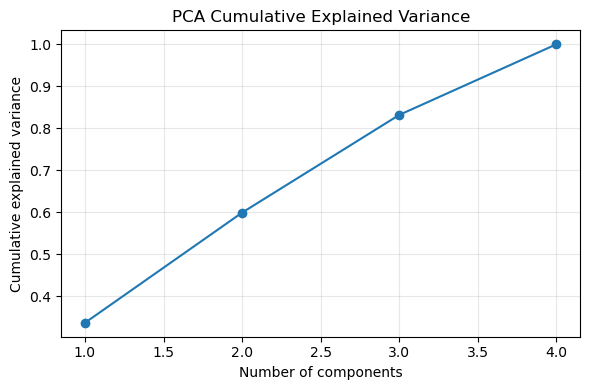

In [51]:
pca_full = PCA().fit(X_scaled)
var_ratio = pca_full.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("pca_explained_variance.png", dpi=300, bbox_inches="tight")
plt.show()